# Portfolio Project on Biodiversity in National Parks
The purpose of this notebook is to use data exploration, visualisation and inference techniques to gain understanding of the following datasets. <br>
<br>
species_info.csv - contains data about different species and their conservation status. <br>
observations.csv - holds recorded sightings of different species at several national parks for the past 7 days.

This notebook will answer the following research questions. <br>
<br>
What is the distribution of conservation statuses? <br>
Are certain types of species more likely to be endangered? <br>
Are the differences between species and their conservation status significant? <br>
Which species were spotted the most at each park?

First we will import the relevant libraries.

In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

We will load the datasets into pandas dataframes then read the first 5 rows of each dataframe and perform some summary statistics to gain understanding of the contents of each dataframe.

In [19]:
print('Species Info')
species = pd.read_csv('species_info.csv')
print(species.head(5))
print('')
print('Observations')
observations = pd.read_csv('observations.csv')
print(observations.head(5))

Species Info
  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  
0                           Gapper's Red-Backed Vole                 NaN  
1                              American Bison, Bison                 NaN  
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...                 NaN  
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)                 NaN  
4                                      Wapiti Or Elk                 NaN  

Observations
            scientific_name                            park_name  observations
0        Vicia benghalensis  Great Smoky Mountains National Park            68
1            Neovison vison  Great Smoky Mountains National Park            77
2         Prunu

From observing the first 5 rows of each dataframe, we see that the new dataframe _species_ has columns _category, scientific_name, common_names_ and _conservation_status_. The new dataframe _observations_ has columns _scientific_name, park_name_ and _observations_. <br>

We have also learnt that _conservation_status_ has missing values.

It makes sense to merge these tables on the common variable _scientific_name_ so that insights can be more easily visualised across the two tables. <br>

However before we can do this, we must first deal with any missing values in either dataframe since merge will fill in any column witout matching data as NaN and check for duplicates of _scientific_name_ in _species_ which will cause more duplicates if unremoved before a merge.

In [24]:
print('Null Values in Species Info')
print(species.isna().sum())
print('\nNull Values in Observations')
print(observations.isna().sum())

Null Values in Species Info
category                  0
scientific_name           0
common_names              0
conservation_status    5633
dtype: int64

Null Values in Observations
scientific_name    0
park_name          0
observations       0
dtype: int64


We have found out that only _conservation_status_ contains null values.

In [26]:
species.conservation_status.value_counts()

conservation_status
Species of Concern    161
Endangered             16
Threatened             10
In Recovery             4
Name: count, dtype: int64

By getting more information about the counts of different values of _conservation_status_, we see that the status is either _Species of Concern, Endangered, Threatened,_ or _In Recovery_. <br>
We can use this context to infer that the _NaN_ values represent species without a conservation status. <br>
Therefore this is structurally missing data. <br>
We can navigate this by filling any _NaN_ values for _conservation_status_ with a new value 'No Conservation Status'.

In [29]:
species['conservation_status'] = species['conservation_status'].fillna('No Conservation Status')

In [30]:
print(species.head(5))

  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names     conservation_status  
0                           Gapper's Red-Backed Vole  No Conservation Status  
1                              American Bison, Bison  No Conservation Status  
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...  No Conservation Status  
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)  No Conservation Status  
4                                      Wapiti Or Elk  No Conservation Status  


Now that we have dealt with all missing values, we just need to investigate for duplicates in _scientific_name_ in the _species_ dataframe before we merge.

In [34]:
print('Species Unique Values')
print(species.nunique())
print('\nShape of Species Dataframe')
print(species.shape)

Species Unique Values
category                  7
scientific_name        5541
common_names           5504
conservation_status       5
dtype: int64

Shape of Species Dataframe
(5824, 4)


We see that _species_ has 5,824 rows but only 5,541 unique species according to _scientific_name_ so there are duplicates present in this column. <br>

To solve this we will group rows by _scientific_name_ in the species table. If duplicates are caused by differences in _common_names_ we will aggregate these into a list of distinct common names.  <br>

If duplicates are caused by differences in _conservation_status_ we will choose the worst case scenario to ensure that the danger to the species is not understated. <br>
To do this we will make _conservation_status_ an ordinal categorical variable.

In [35]:
status_order = [
    'No Conservation Status',
    'Species of Concern',
    'Threatened',
    'Endangered',
    'In Recovery'
]

In [36]:
species['conservation_status'] = pd.Categorical(
    species['conservation_status'],
    categories=status_order,
    ordered=True
)

In [38]:
species = species.groupby('scientific_name').agg({
    'common_names': lambda x: ', '.join(sorted(set(x))),
    'category': 'first',                # take first value (assuming it's the same across duplicates)
    'conservation_status': 'last'      # same here
}).reset_index()

print(species.shape)

(5541, 4)


Finally we can see that species now has the same number of rows as distinct scientific names. We can now merge the two tables. <br>

Since the variables of most interest are _conservation_status_ and _observations_ we will merge the _species_ dataframe onto the _observations_ dataframe so that the rows of the new dataframe will be the rows from the _observations_ dataframe, with the _species_ info data added on where _scientific_name_ matches. <br>

In [40]:
df = pd.merge(left=species, right=observations, on='scientific_name', how='right')
print('Shape of Observations Dataframe')
print(observations.shape)
print('\nShape of New Dataframe Df')
print(df.shape)

Shape of Observations Dataframe
(23296, 3)

Shape of New Dataframe Df
(23296, 6)


The new dataframe _df_ has the same number of rows as _observations_ but three extra columns as expected. <br>

In [41]:
print(df.isna().sum())

scientific_name        0
common_names           0
category               0
conservation_status    0
park_name              0
observations           0
dtype: int64


The new dataframe has no null values so every scientific name in _observations_ has been matched to a scientific name in _species_.

Now that we have a combined dataset we will explore the dataset using summary statistics.

In [13]:
df.nunique()

scientific_name        5541
common_names           5237
category                  7
conservation_status       5
park_name                 4
observations            304
dtype: int64

A count of unique values reveals that our dataframe describes observations of 7 categories of 5,540 distinct species across 4 different national parks.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23296 entries, 0 to 23295
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   scientific_name      23296 non-null  object  
 1   common_names         23296 non-null  object  
 2   category             23296 non-null  object  
 3   conservation_status  23296 non-null  category
 4   park_name            23296 non-null  object  
 5   observations         23296 non-null  int64   
dtypes: category(1), int64(1), object(4)
memory usage: 568.9+ KB


We see that _df_ has 23,296 rows. All variables have the datatype _object_ which is expected for strings, except _conservation_status_ which we made categorical and _observations_ which has datatype _int64_ as expected for a counting variable. <br>

In [43]:
df.describe(include='all')

,scientific_name,common_names,category,conservation_status,park_name,observations
count,23296,23296,23296,23296,23296,23296.000000
unique,5541,5237,7,5,4,NaN
top,Myotis lucifugus,Brachythecium Moss,Vascular Plant,No Conservation Status,Great Smoky Mountains National Park,NaN
freq,12,28,17880,22528,5824,NaN
mean,NaN,NaN,NaN,NaN,NaN,142.287904
std,NaN,NaN,NaN,NaN,NaN,69.890532
min,NaN,NaN,NaN,NaN,NaN,9.000000
25%,NaN,NaN,NaN,NaN,NaN,86.000000
50%,NaN,NaN,NaN,NaN,NaN,124.000000
75%,NaN,NaN,NaN,NaN,NaN,195.000000


The most frequent park recorded is Great Smoky Mountains National Park which is interesting because it represents exactly 25% of the data so observations must be evenly distributed between the 4 parks.

We also see that 77% of species observed in this dataset come under the category Vascular Plant.

In [88]:
colours = [
    'lightcoral',
    'lightsalmon',
    'palegoldenrod',
    'lightgreen',
    'lightcyan',
    'paleturquoise',
    'lightblue',
    'plum',
    'lavender',
    'thistle',
    'pink',
    'mistyrose',
    'peachpuff',
    'wheat',
    'powderblue',
    'honeydew',
    'mintcream'
]

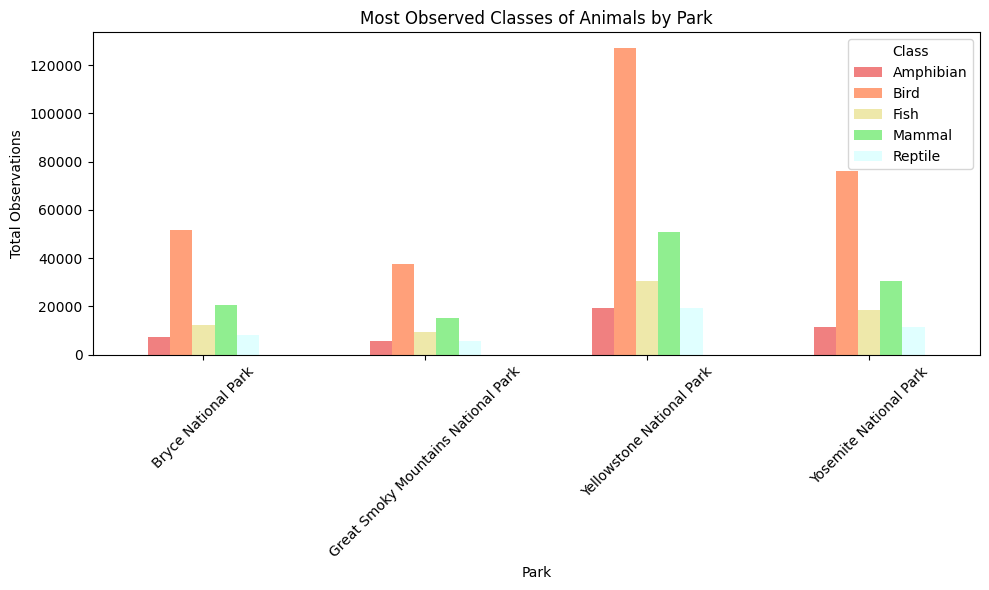

In [124]:
filtered_df = df[~df['category'].isin(['Vascular Plant', 'Nonvascular Plant'])]
grouped = filtered_df.groupby(['park_name', 'category'])['observations'].sum().reset_index()
pivot_table = grouped.pivot(index='park_name', columns='category', values='observations')
pivot_table.plot(kind='bar', figsize=(10, 6), color=colours)
plt.xlabel('Park')
plt.ylabel('Total Observations')
plt.title('Most Observed Classes of Animals by Park')
plt.xticks(rotation=45)
plt.legend(title='Class')
plt.tight_layout()
plt.show()

The above grouped bar chart shows that Yellowstone National Park is the best for bird-spotting and the least animal observations occured in the Great Smoky Mountains.

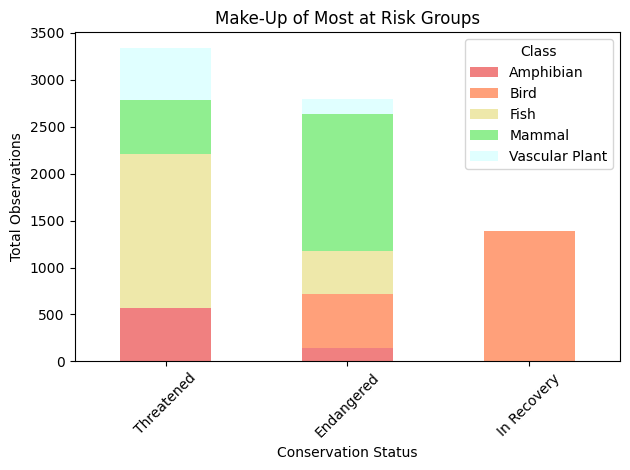

In [144]:
obs_sum = df[(df['conservation_status'] != 'No Conservation Status') & (df['conservation_status'] != 'Species of Concern')].groupby(['conservation_status', 'category'], observed=True)['observations'].sum().unstack()
obs_sum.plot(kind='bar', stacked=True, color=colours)
plt.xticks(rotation=45)
plt.legend(title='Class')
plt.xlabel('Conservation Status')
plt.ylabel('Total Observations')
plt.title('Make-Up of Most at Risk Groups')
plt.tight_layout()
plt.show()

The above stacked bar chart shows that the most threatened species observed were fish and the most endangered species observed were mammals. Whilst many birds observed were endangered, more were in recovery.

Wordcloud of Most Observed Species


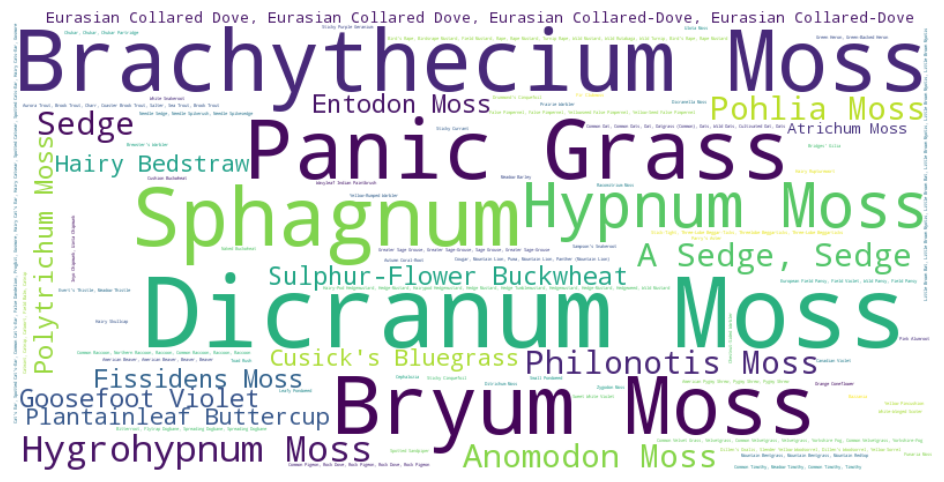

In [142]:
print('Wordcloud of Most Observed Species')
from wordcloud import WordCloud
species_counts = df.groupby('common_names')['observations'].sum()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(species_counts)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The above WordCloud shows that we can expect a lot of moss at any park.